# Plot counts of common virus infection in macaques
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7150127/

In [1]:
bp = "PRJNA665227"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"
u_tax = f"/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

In [2]:
import anndata
import numpy as np
from scipy import stats, linalg
import pandas as pd
import json
import gget
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
%config InlineBackend.figure_format='retina'
%load_ext blackcellmagic

import scanpy as sc
# sc.set_figure_params(figsize=(6, 6), frameon=False)
# sc.settings.n_jobs=2

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

def flatten(xss):
    """
    Function to flatten array of arrays.
    """
    return [x for xs in xss for x in xs]

Thu Nov 30 22:21:43 2023 INFO Generating grammar tables from /home/laura/anaconda3/lib/python3.9/site-packages/blib2to3/Grammar.txt
Thu Nov 30 22:21:43 2023 INFO Writing grammar tables to /home/laura/.cache/black/21.12b0/Grammar3.9.12.final.0.pickle
Thu Nov 30 22:21:43 2023 INFO Writing failed: [Errno 2] No such file or directory: '/home/laura/.cache/black/21.12b0/tmpfjkep18k'
Thu Nov 30 22:21:43 2023 INFO Generating grammar tables from /home/laura/anaconda3/lib/python3.9/site-packages/blib2to3/PatternGrammar.txt
Thu Nov 30 22:21:43 2023 INFO Writing grammar tables to /home/laura/.cache/black/21.12b0/PatternGrammar3.9.12.final.0.pickle
Thu Nov 30 22:21:43 2023 INFO Writing failed: [Errno 2] No such file or directory: '/home/laura/.cache/black/21.12b0/tmpv6agk4hd'


___
# Load data

In [3]:
palmdb_adata = anndata.read(f"{fastq_folder}/host_flag/virus_cdna_dna_masked_meta.h5ad")
palmdb_adata

AnnData object with n_obs × n_vars = 225898 × 11176
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species', 'dpi_clean_merged'
    var: 'v_type'

Load ID to phylogeny mapping:

In [4]:
id2tax = pd.read_csv(u_tax)
id2tax

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


____

In [5]:
## -> family
# -> genus that had no counts
genera_to_test = [
    ### Nonenveloped RNA-Containing Viruses
    
    ## Reoviridae
    "Orthoreovirus",
    "Rotavirus",
    
    ## Picornaviridae
    "Cardiovirus",
    "Enterovirus",
    "Hepatovirus",
    "Sapelovirus",
    
    # Caliciviridae
    "Norovirus",
    "Recovirus",
    "Vesivirus",
    
    ## Coronaviridae
    "Alphacoronavirus",
    "Betacoronavirus",
    "Deltacoronavirus",
    "Gammacoronavirus",
    
    ## Hepeviridae
    'Orthohepevirus',
    'Piscihepevirus',
    
    ### Enveloped RNA-Containing Viruses
    
    ## Arenaviridae
    "Arenavirus",
    "Mammarenavirus",
    
    ## Flaviviridae
    "Hepacivirus",
    "Flavivirus",
    "Pestivirus",
    
    # Togaviridae
    "Alphavirus",
    "Rubivirus",
    
    # Arteriviridae
    "arterivirus",
    
    # Paramyxoviridae
    "Morbillivirus",
    "Metapneumovirus",
    "Respirovirus",
    
    ## Orthomyxoviridae
    'Alphainfluenzavirus', 
    'Betainfluenzavirus',
    'Deltainfluenzavirus',
    'Gammainfluenzavirus',
    
    # Filoviridae
    "Ebolavirus", 
    "Marburgvirus",
    
    # Rhabdoviridae
    "Lyssavirus",
]

In [6]:
def rand_jitter(arr, jitter_size=0.02):
    """
    Add random jitter to array to avoid overplotting.
    """
    return np.random.uniform(low=-jitter_size, high=jitter_size, size=(len(arr),))

In [7]:
# Define order of animals
animal_ids = [ 
    'NHP1',
    'NHPC1',
    'NHP2',
    'NHP08',
    'NHP09',
    'NHP10',
    'NHP11',
    'NHP12',
    'NHP13',
    'NHP14',
    'NHP15',
    'NHP16',
    'NHP17',
    'NHP18',
    'NHP19',
    'NHP20',
    'NHP22',
    'NHP23',
    'NHP24',
]

In [8]:
len(animal_ids)

19

In [9]:
len(list(palmdb_adata.obs["donor_animal"].unique()))

19

In [10]:
# Only keep cells that passed macaque QC and viruses that were unique to macaque
# palmdb_adata = palmdb_adata[palmdb_adata.obs["celltype"].notnull(), palmdb_adata.var["v_type"] == "macaca_only"].copy()
# palmdb_adata = palmdb_adata[palmdb_adata.obs["celltype"].notnull(), palmdb_adata.var["v_type"] != "below_threshold"].copy()
# palmdb_adata = palmdb_adata[palmdb_adata.obs["celltype"].notnull(), :].copy()

CPU times: user 1min 11s, sys: 915 ms, total: 1min 12s
Wall time: 1min 11s


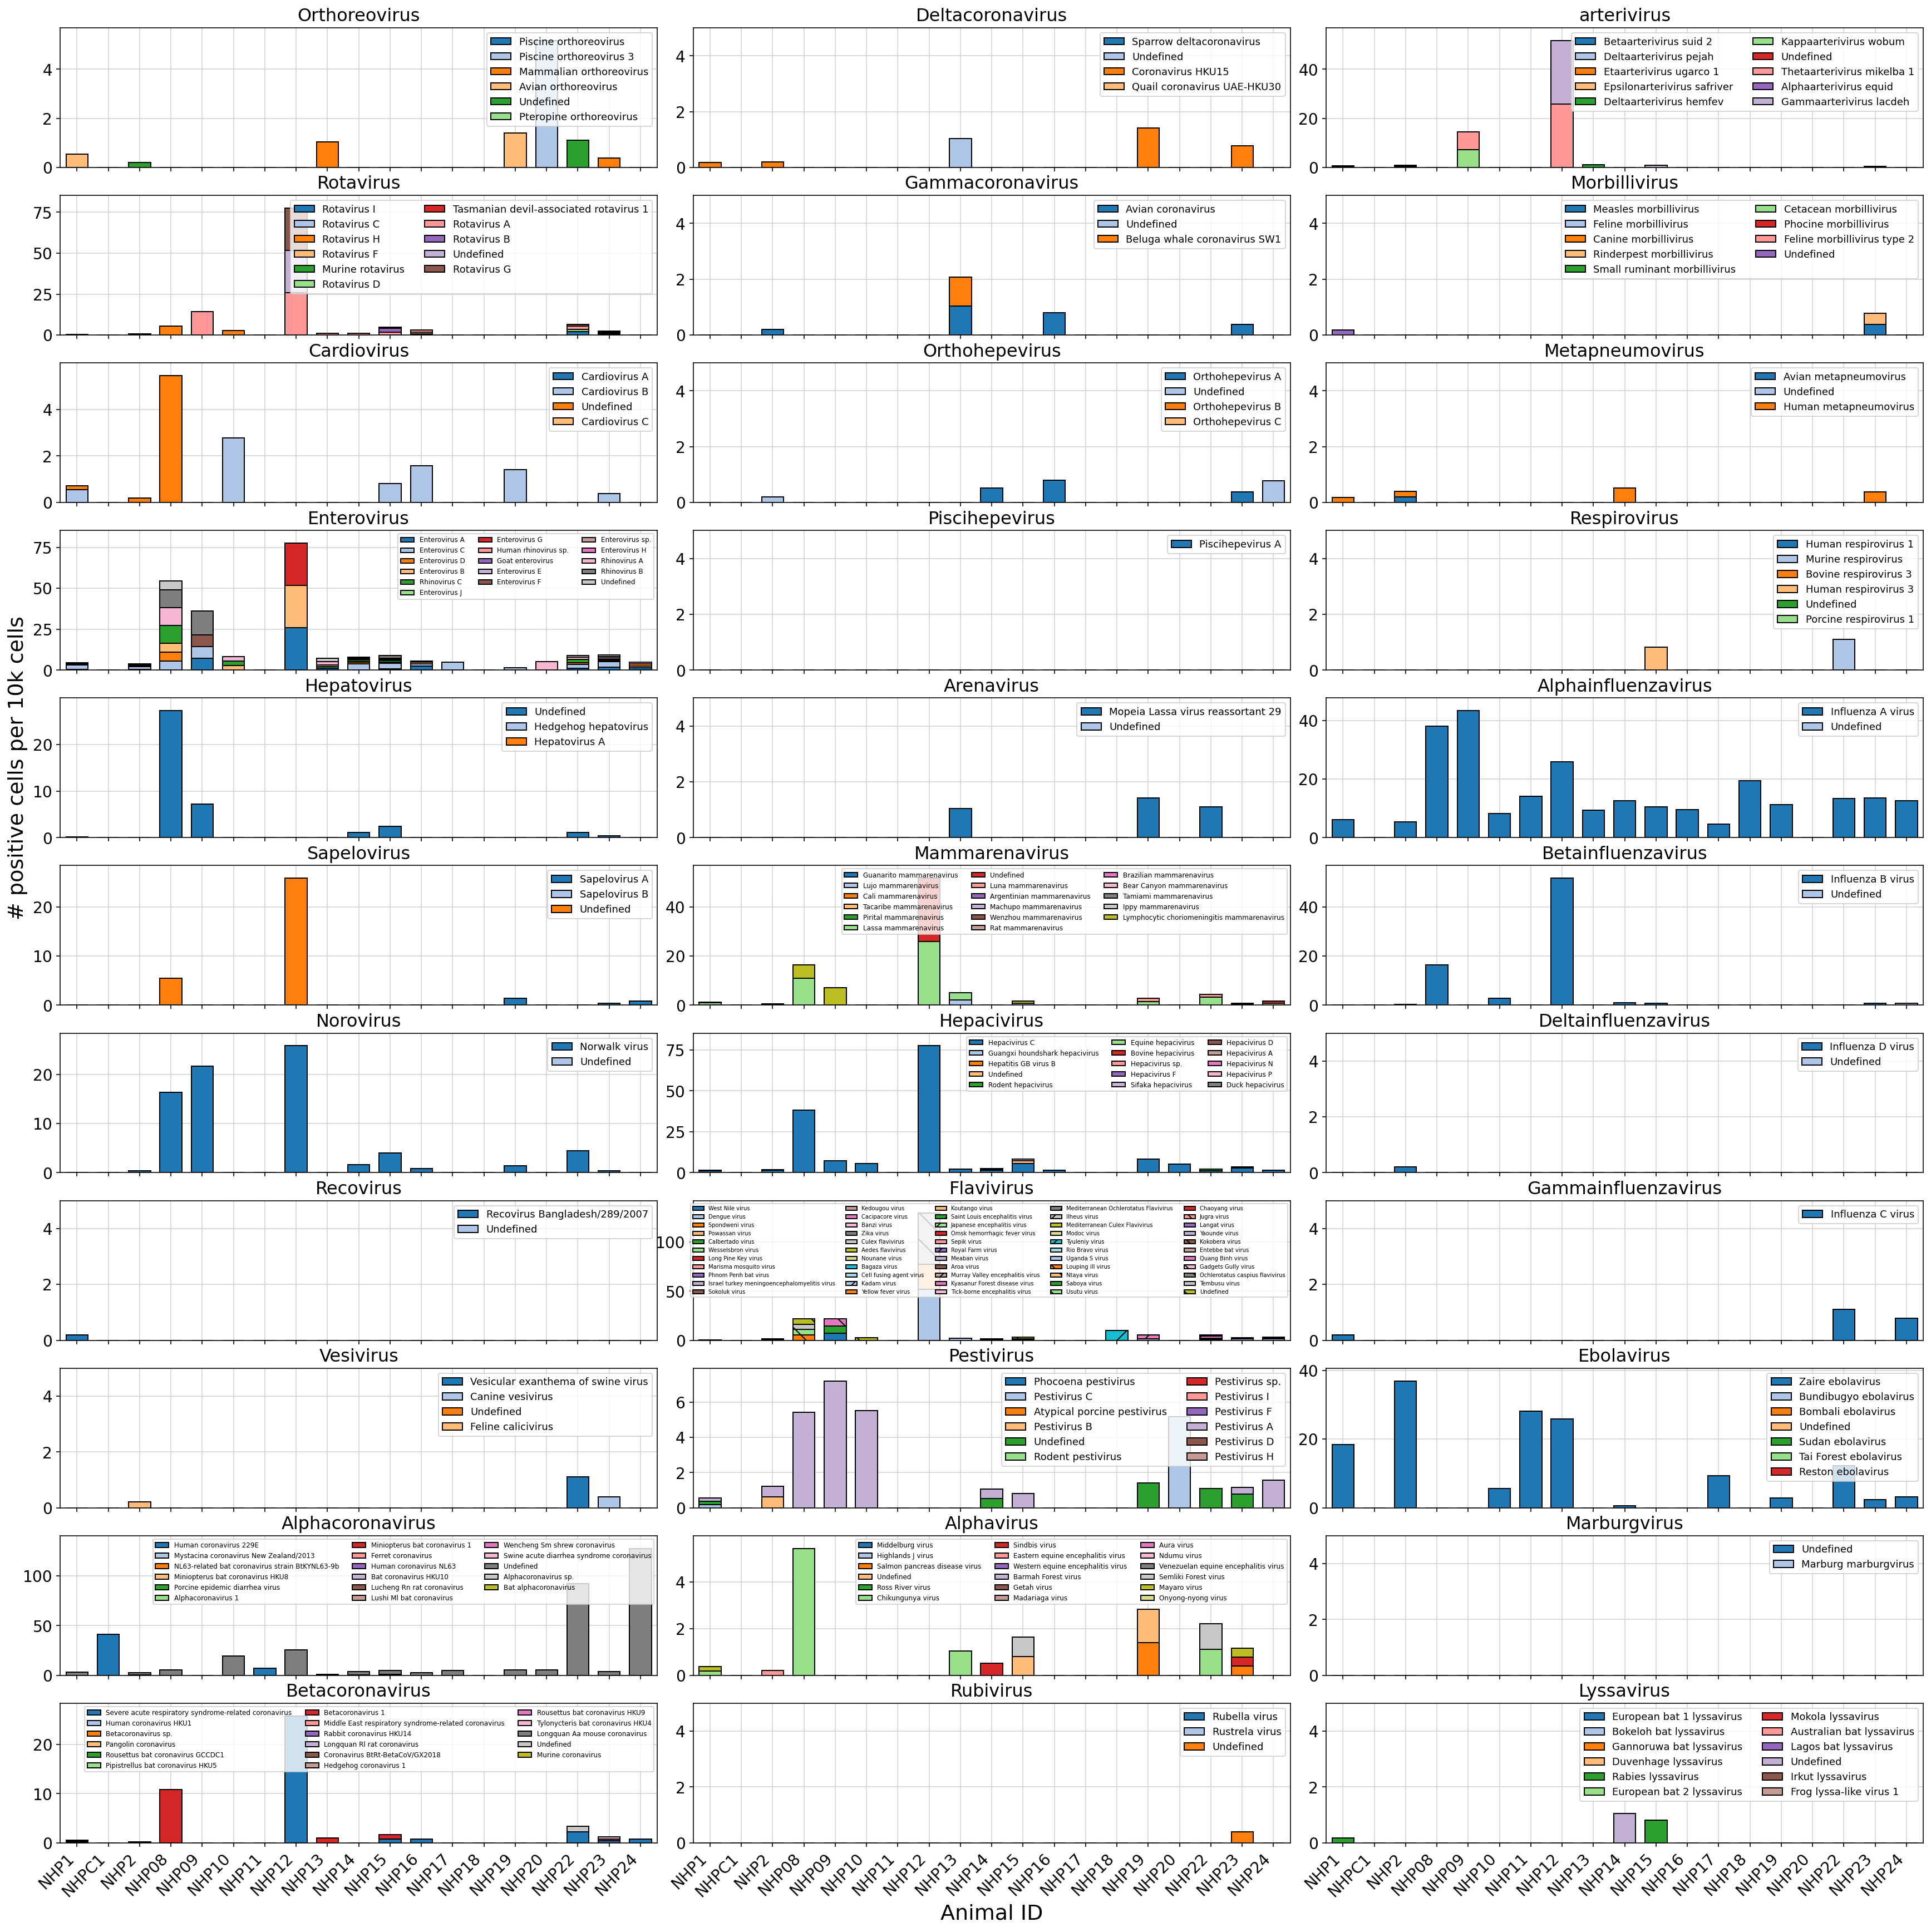

In [39]:
%%time
fig, axs = plt.subplots(figsize=(30,30), nrows=int(len(genera_to_test)/3), ncols=3, sharex=True)
fontsize = 14
width = 0.7
NUM_COLORS = 20

x = np.arange(len(animal_ids))

col_idx = 0
row_idx = 0
for genus in genera_to_test:
    target_species = id2tax[id2tax["genus"].str.contains(genus)]["species"].unique()
    
    color_idx = 0
    second_hatch_round=False
    hatch = None
    low_counts = True
    bottoms = np.zeros(len(animal_ids))
    for species in target_species:
        target_ids = id2tax[(id2tax["genus"].str.contains(genus)) & (id2tax["species"] == species)]["rep_ID"].unique()
        
        # Check if virus IDs are in adata
        if len(palmdb_adata.var[palmdb_adata.var.index.isin(target_ids)]) > 0:
            counts = []
            for i, animal in enumerate(animal_ids):
                num_cells = len(
                    palmdb_adata[
                        palmdb_adata.obs["donor_animal"] == animal,
                        palmdb_adata.var.index.isin(target_ids)
                    ]
                )

                # Number of virus+ cells
                num_cells_virus = palmdb_adata[
                            palmdb_adata.obs["donor_animal"] == animal,
                            palmdb_adata.var.index.isin(target_ids)
                        ].X.sum()

                # Count per 10k cells
                norm_count = (num_cells_virus / num_cells) * 10000

                counts.append(norm_count)
        else:
            counts = np.zeros(len(animal_ids))
            
        if species == ".":
            label = "Undefined"
        else:
            label = species
            
        ax = axs[row_idx, col_idx]
        ax.bar(x, counts, bottom=bottoms, width=width, label=label, hatch=hatch, color=plt.cm.tab20(color_idx), edgecolor="black")
            
        if color_idx == NUM_COLORS-1 and not second_hatch_round:
            hatch = "/"
            second_hatch_round = True
            color_idx = 0
        elif color_idx == NUM_COLORS-1 and second_hatch_round:
            hatch = "\\"
            color_idx = 0
            
        bottoms = bottoms + np.array(counts)
        color_idx += 1
        
        if np.max(bottoms) >= 5:
            low_counts = False
        
    # ax.text(x[i], norm_count, "{:,}".format(num_cells), ha="center", va="bottom", fontsize=fontsize-7)
    
    ax.set_title(genus, fontsize=fontsize+2)
    if col_idx == 0:
        if row_idx == 4:
            ax.set_ylabel("# positive cells per 10k cells", fontsize=fontsize+5)
            
    if col_idx == 1:
        if row_idx == len(genera_to_test) / 3 - 1:
            ax.set_xlabel("Animal ID", fontsize=fontsize+5)
    ax.tick_params(axis="both", labelsize=fontsize)
    ax.set_xticks(x)
    
    if low_counts:
        ax.set_ylim(bottom=0, top=5)
    else:
        ax.set_ylim(bottom=0, top=np.max(bottoms)+np.max(bottoms)*0.1)

    if len(target_species)>8 and len(target_species)<15:
        # ax.legend(fontsize=fontsize-2, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
        ax.legend(fontsize=fontsize-5, loc='upper right', ncol=2)
    elif len(target_species)>=15 and len(target_species)<50:
        # ax.legend(fontsize=fontsize-2, loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
        ax.legend(fontsize=fontsize-8, loc='upper right', ncol=3)
    elif len(target_species)>=50:
        # ax.legend(fontsize=fontsize-2, loc='center left', bbox_to_anchor=(1, 0.5), ncol=5)
        ax.legend(fontsize=fontsize-9, loc='upper right', ncol=5)
    else:
        # ax.legend(fontsize=fontsize-2, loc='center left', bbox_to_anchor=(1, 0.5))
        ax.legend(fontsize=fontsize-5, loc='upper right')
    
    ax.grid(True, which="both", color="lightgray")
    ax.set_axisbelow(True)
    
    ax.margins(0.01)
    
    row_idx += 1
    if row_idx == len(genera_to_test) / 3:
        ax.set_xticklabels(animal_ids, rotation=45, ha="right", fontsize=fontsize)
        row_idx = 0
        col_idx += 1

plt.subplots_adjust(hspace=0.2, wspace=0.06)

# plt.tight_layout()

plt.savefig(
    f"figures/4.4_common_macaque_infection_counts_QC_bus+d-list.png",
    bbox_inches="tight",
    dpi=300
)

fig.show()

Only plot viruses with positive counts:

In [24]:
# %%time

# genera_sublist = ["Rotavirus", "Enterovirus", "Alphacoronavirus", "Orthohepevirus", "Mammarenavirus", "Hepacivirus", "Flavivirus", "Alphainfluenzavirus"]
# target_species = ["Rotavirus A", "Enterovirus G", ".", ".", "Lassa mammarenavirus", "Hepacivirus C", "Dengue virus", "Influenza A virus"]

# fig, axs = plt.subplots(figsize=(10,len(genera_sublist)*2), nrows=len(genera_sublist), sharex=True)
# fontsize = 14
# width = 0.6
# NUM_COLORS = 20

# x = np.arange(len(animal_ids))
# add_cell_counts = True

# for ax, genus, species in zip(axs, genera_sublist, target_species):
    
#     target_ids = id2tax[(id2tax["genus"].str.contains(genus)) & (id2tax["species"] == species)]["rep_ID"].unique()

#     # Check if virus IDs are in adata
#     if len(palmdb_adata.var[palmdb_adata.var.index.isin(target_ids)]) > 0:
#         counts = []
#         ncs = []
#         for i, animal in enumerate(animal_ids):
#             num_cells = len(
#                 palmdb_adata[
#                     palmdb_adata.obs["donor_animal"] == animal,
#                     palmdb_adata.var.index.isin(target_ids)
#                 ]
#             )
#             ncs.append(num_cells)

#             # Number of virus+ cells
#             num_cells_virus = palmdb_adata[
#                         palmdb_adata.obs["donor_animal"] == animal,
#                         palmdb_adata.var.index.isin(target_ids)
#                     ].X.sum()

#             # Count per 10k cells
#             norm_count = (num_cells_virus / num_cells) * 10000

#             counts.append(norm_count)

#         if species == ".":
#             label = f"{genus} sp."
#         else:
#             label = species

#         ax.bar(x, counts, width=width, color="tab:red", edgecolor="black")
        
#     if add_cell_counts:
#         for nc, idx in zip(ncs, x):
#             ax.text(idx, 265, "{:,}".format(nc), ha="center", va="bottom", fontsize=fontsize-5)      
#         ax.set_title(label, fontsize=fontsize+2, pad=20)       
#         add_cell_counts = False
#     else:
#         ax.set_title(label, fontsize=fontsize+2)
    
#     # Add 10% space above bars
#     # ax.set_ylim(bottom=0, top=np.max(counts)+np.max(counts)*0.1)
#     ax.set_ylim(bottom=0, top=260)
    
#     ax.set_ylabel("# positive cells\nper 10k cells", fontsize=fontsize)
#     ax.tick_params(axis="both", labelsize=fontsize)
#     ax.set_xticks(x)
    
#     ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
#     ax.set_axisbelow(True)
    
#     ax.margins(0.01)
    
# ax.set_xticklabels(animal_ids, rotation=45, ha="right", fontsize=fontsize)
# ax.set_xlabel("Animal", fontsize=fontsize)

# # plt.subplots_adjust(hspace=0.05)

# plt.tight_layout()

# plt.savefig(
#     f"figures/4.4_common_macaque_infection_counts_QC_bwa.png",
#     bbox_inches="tight",
#     dpi=300
# )

# fig.show()

___

# Compute and plot partial correlation matrix between viruses 
https://gist.github.com/fabianp/9396204419c7b638d38f

In [25]:
# def partial_corr(C):
#     """
#     Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#     for the remaining variables in C.
#     Parameters
#     ----------
#     C : array-like, shape (n, p)
#         Array with the different variables. Each column of C is taken as a variable
#     Returns
#     -------
#     P : array-like, shape (p, p)
#         P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#         for the remaining variables in C.
#     """

#     C = np.asarray(C)
#     p = C.shape[1]
#     P_corr = np.zeros((p, p), dtype=np.float)
    
#     for i in range(p):
#         P_corr[i, i] = 1
#         for j in range(i+1, p):
#             idx = np.ones(p, dtype=np.bool)
#             idx[i] = False
#             idx[j] = False
#             beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
#             beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

#             res_j = C[:, j] - C[:, idx].dot( beta_i)
#             res_i = C[:, i] - C[:, idx].dot(beta_j)

#             corr = stats.pearsonr(res_i, res_j)[0]
#             P_corr[i, j] = corr
#             P_corr[j, i] = corr

#     return P_corr

In [26]:
# fig, axs = plt.subplots(figsize=(60, 30), nrows=3, ncols=6)

# genera_sublist = ["Rotavirus", "Enterovirus", "Alphacoronavirus", "Orthohepevirus", "Mammarenavirus", "Hepacivirus", "Flavivirus", "Alphainfluenzavirus", "Ebolavirus"]
# target_species = ["Rotavirus A", "Enterovirus G", ".", ".", "Lassa mammarenavirus", "Hepacivirus C", "Dengue virus", "Influenza A virus", "Zaire ebolavirus"]

# row_idx = 0
# col_idx = 0
# for animal in animal_ids:
#     ax = axs[row_idx][col_idx]
    
#     C = []
#     for genus, species in zip(genera_sublist, target_species):
#         target_ids = id2tax[(id2tax["genus"].str.contains(genus)) & (id2tax["species"] == species)]["rep_ID"].unique()
#         # Get all cell counts
#         counts = nd(palmdb_adata[palmdb_adata.obs["donor_animal"] == animal, palmdb_adata.var.index.isin(target_ids)].X.todense())
#         C.append(counts)

#     C = np.array(C)

#     # !!! THIS WILL DEFAULT TO ALL THREADS
#     P_corr = partial_corr(C.T)
#     P_corr.shape

#     im = ax.imshow(P_corr)

#     ax.set_xticks(np.arange(len(genera_sublist)), labels=genera_sublist)
#     ax.set_yticks(np.arange(len(genera_sublist)), labels=genera_sublist)
    
#     ax.set_title(animal)
    
#     if col_idx == 5:
#         col_idx = 0
#         row_idx += 1
#     else:
#         col_idx += 1

# # fig.tight_layout()

# fig.show()

___
# Compute Pearson and Spearman correlations

Plot Pearson correlation of viruses per animal:

ValueError: Length of values (0) does not match length of index (54983)

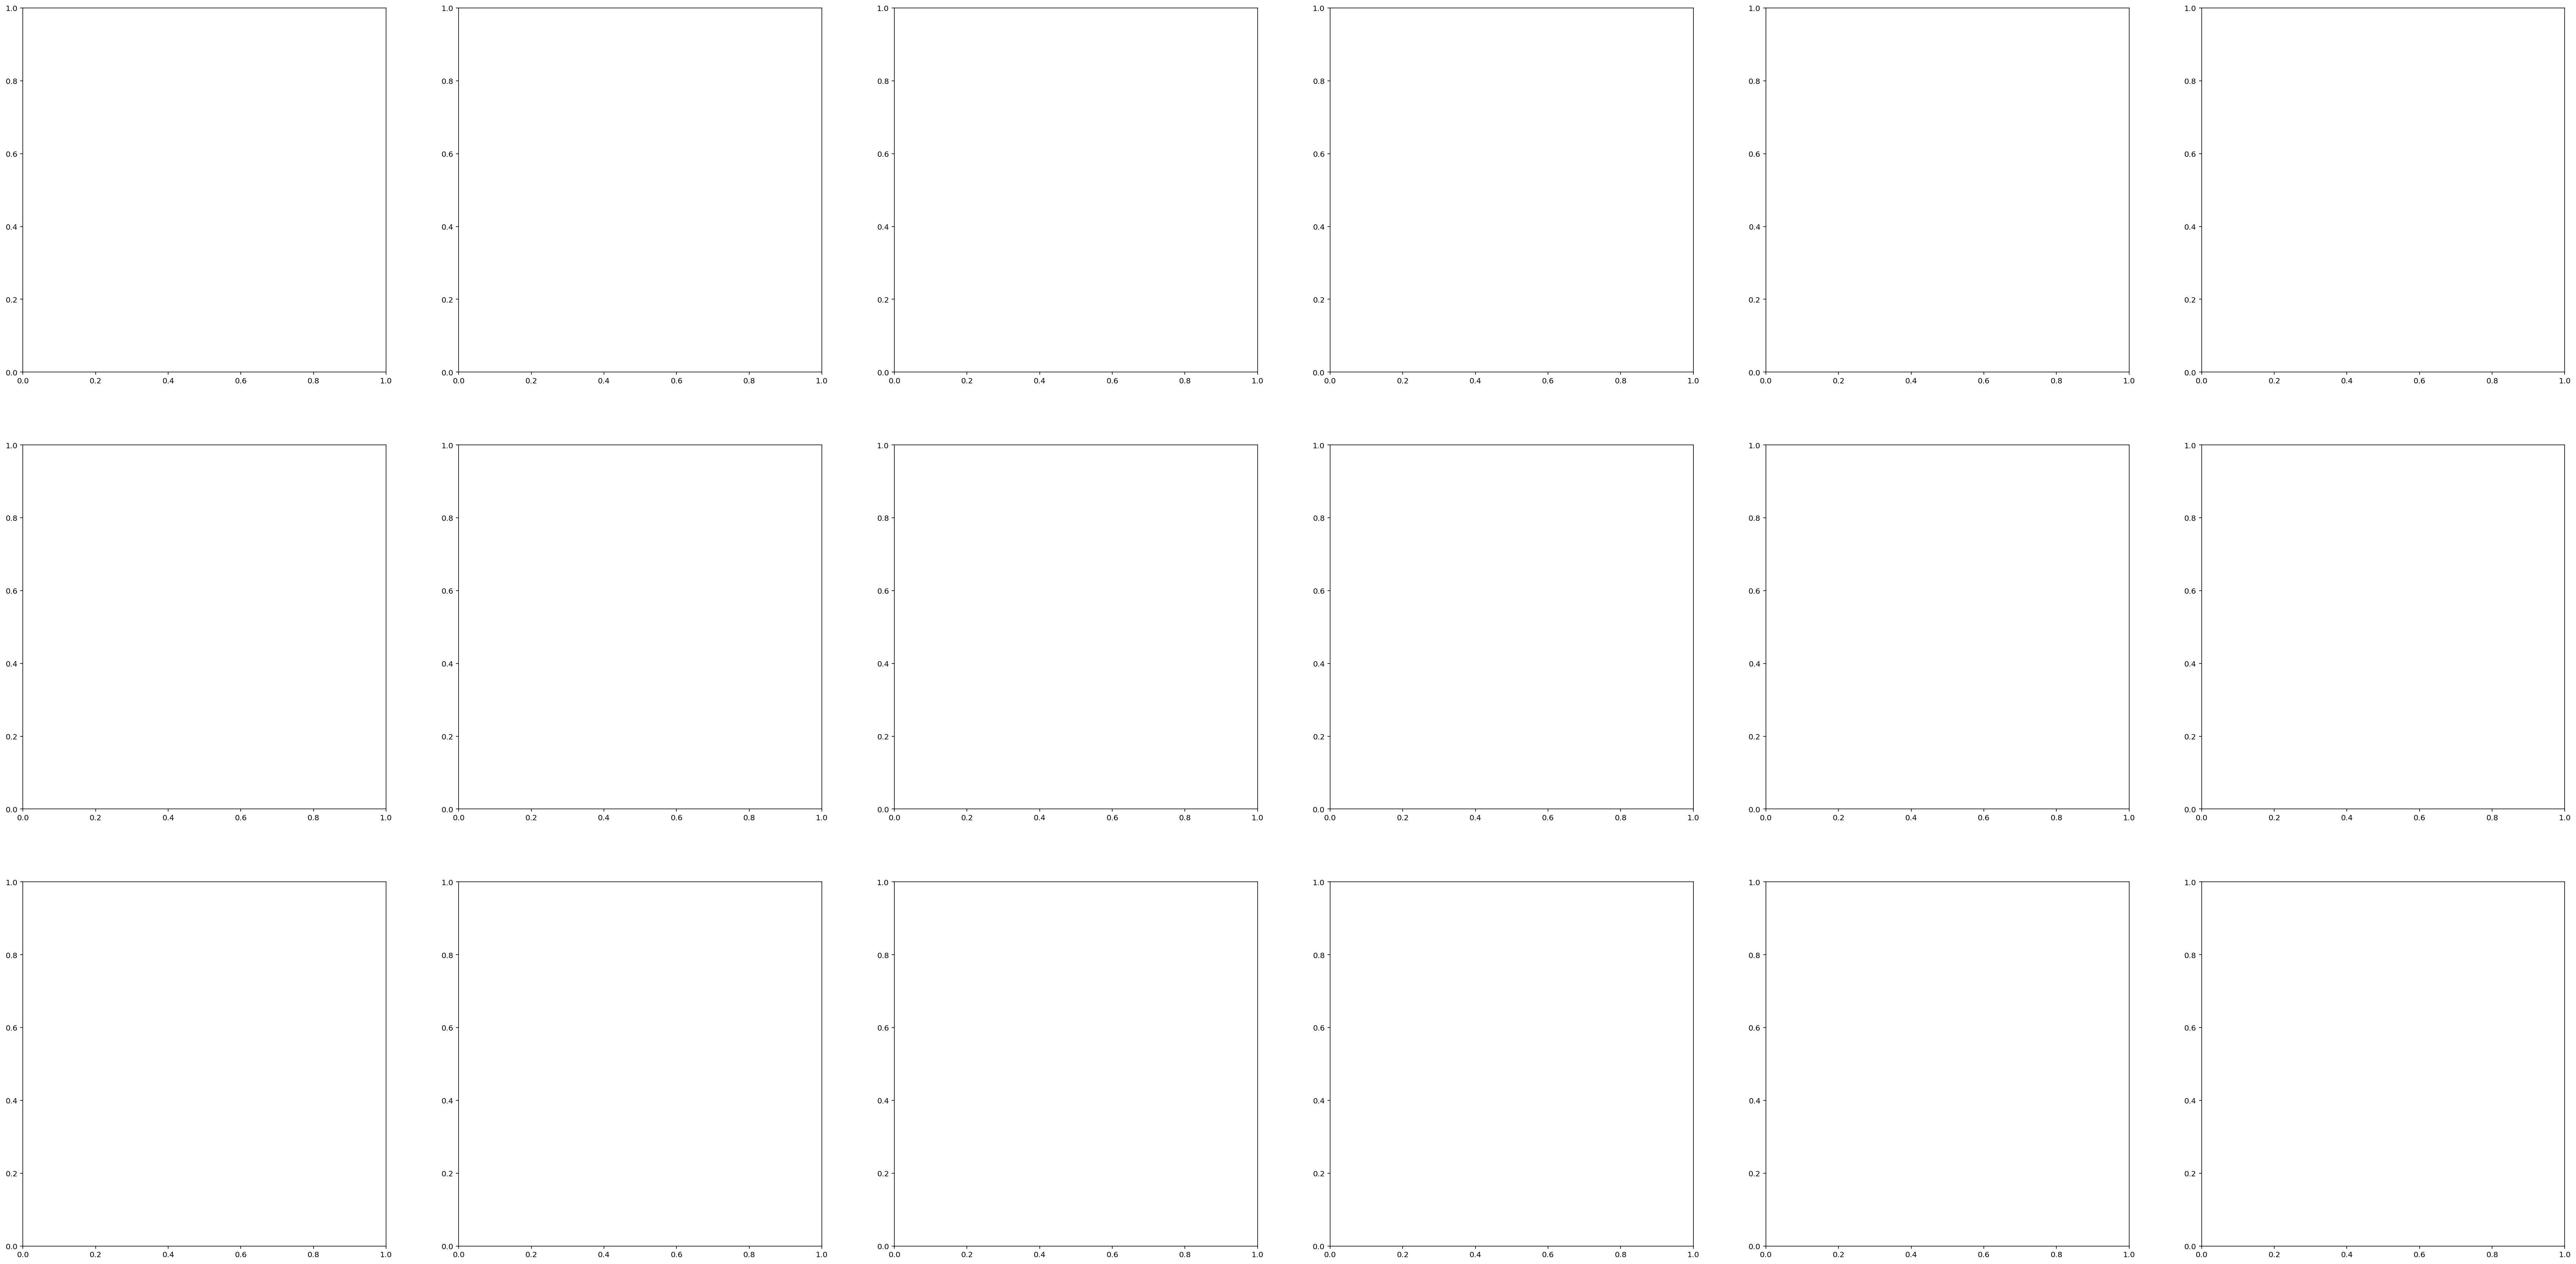

In [27]:
%%time
fig, axs = plt.subplots(figsize=(60, 30), nrows=3, ncols=6)

# Define minimum number of observations required per pair of columns
min_periods = 0
min_pearson = 0.1

genera_sublist = ["Rotavirus", "Enterovirus", "Alphacoronavirus", "Orthohepevirus", "Mammarenavirus", "Hepacivirus", "Flavivirus", "Alphainfluenzavirus", "Ebolavirus"]
target_species = ["Rotavirus A", "Enterovirus G", ".", ".", "Lassa mammarenavirus", "Hepacivirus C", "Dengue virus", "Influenza A virus", "Zaire ebolavirus"]

row_idx = 0
col_idx = 0
for animal in animal_ids:
    C = pd.DataFrame()
    for genus, species in zip(genera_sublist, target_species):
        target_ids = id2tax[(id2tax["genus"].str.contains(genus)) & (id2tax["species"] == species)]["rep_ID"].unique()

        # Get all cell counts
        counts = nd(palmdb_adata[palmdb_adata.obs["donor_animal"] == animal, palmdb_adata.var.index.isin(target_ids)].X.todense())
        C[species] = counts
    
    # Compute Pearson correlations
    pearson = C.corr(method='pearson', min_periods=min_periods)
    
    # Only keep features with correlation greater than min_pearson
    pearson_upper = pearson.where(np.triu(np.ones(pearson.shape), k=1).astype(bool))
    to_keep = [column for column in pearson_upper.columns if any(pearson_upper[column] >= min_pearson)]
    pearson_filtered = pearson[to_keep].loc[to_keep]
    
    # Plot heatmap
    im = ax.imshow(pearson_filtered)

    ax.set_xticks(np.arange(len(pearson_filtered)), labels=pearson_filtered.columns)
    ax.set_yticks(np.arange(len(pearson_filtered)), labels=pearson_filtered.index.values)
    
    ax.set_title(animal)
    
    if col_idx == 5:
        col_idx = 0
        row_idx += 1
    else:
        col_idx += 1
        
fig.show()

ValueError: Length of values (0) does not match length of index (54983)

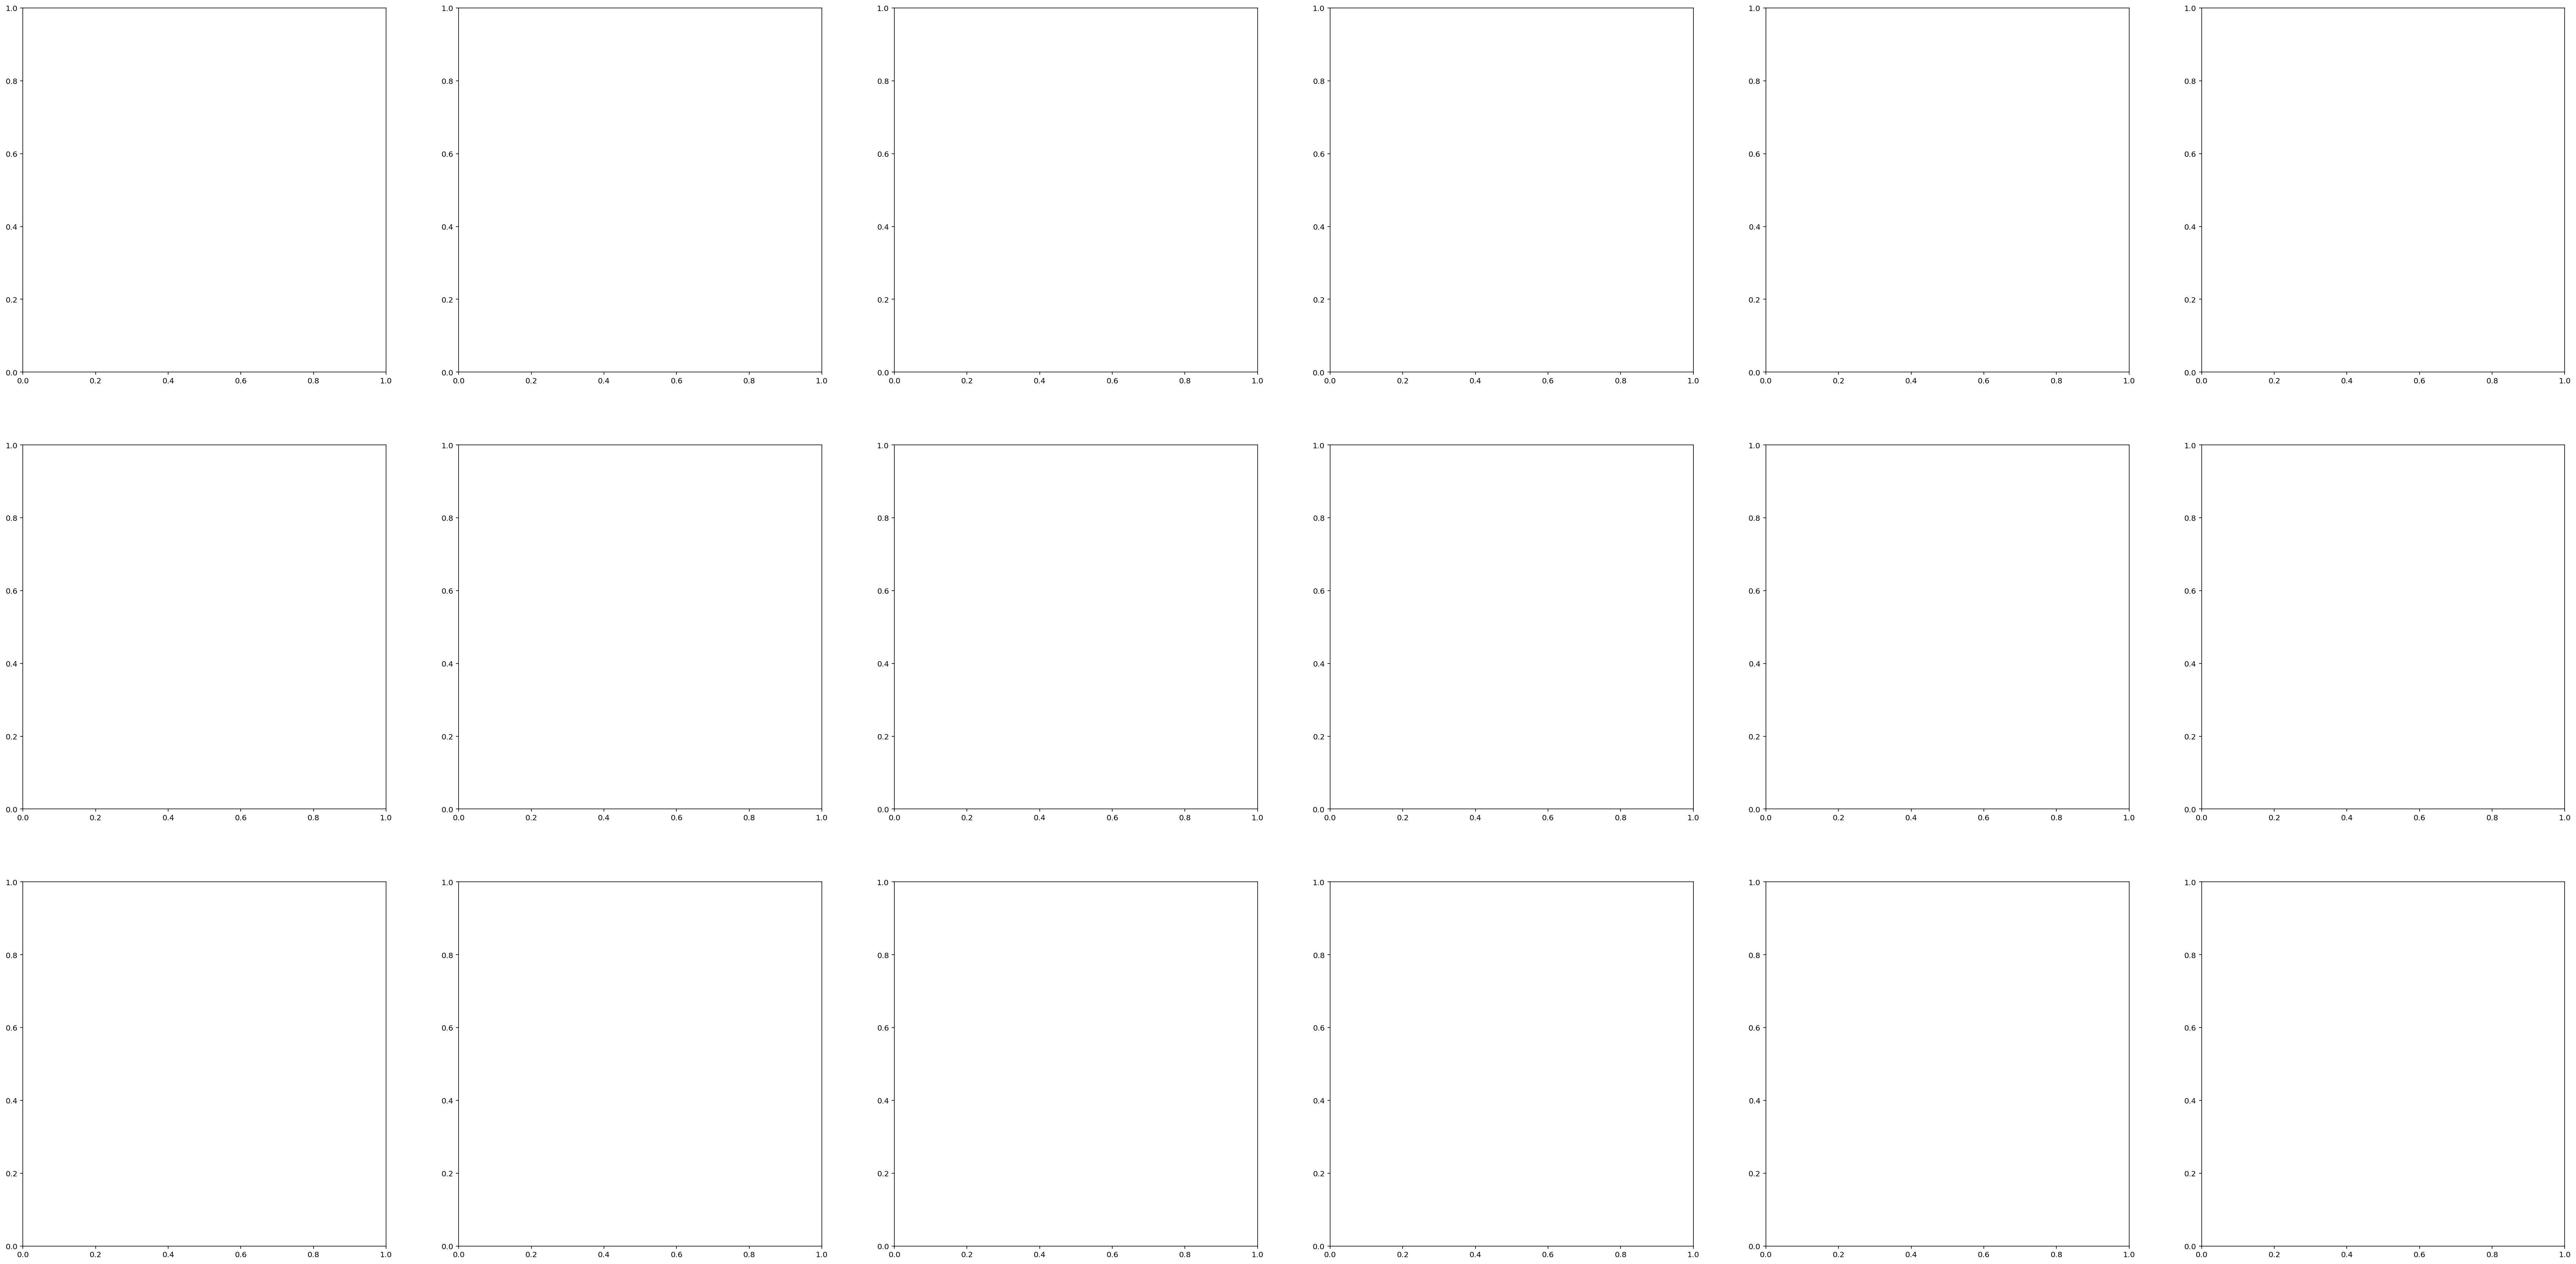

In [28]:
%%time
fig, axs = plt.subplots(figsize=(60, 30), nrows=3, ncols=6)

# Define minimum number of observations required per pair of columns
min_periods = 0
min_pearson = 0.1

genera_sublist = ["Rotavirus", "Enterovirus", "Alphacoronavirus", "Orthohepevirus", "Mammarenavirus", "Hepacivirus", "Flavivirus", "Alphainfluenzavirus", "Ebolavirus"]
target_species = ["Rotavirus A", "Enterovirus G", ".", ".", "Lassa mammarenavirus", "Hepacivirus C", "Dengue virus", "Influenza A virus", "Zaire ebolavirus"]

row_idx = 0
col_idx = 0
for animal in animal_ids:
    C = pd.DataFrame()
    for genus, species in zip(genera_sublist, target_species):
        target_ids = id2tax[(id2tax["genus"].str.contains(genus)) & (id2tax["species"] == species)]["rep_ID"].unique()

        # Get all cell counts
        counts = nd(palmdb_adata[palmdb_adata.obs["donor_animal"] == animal, palmdb_adata.var.index.isin(target_ids)].X.todense())
        C[species] = counts
    
    # Compute Pearson correlations
    pearson = C.corr(method='spearman', min_periods=min_periods)
    
    # Only keep features with correlation greater than min_pearson
    pearson_upper = pearson.where(np.triu(np.ones(pearson.shape), k=1).astype(bool))
    to_keep = [column for column in pearson_upper.columns if any(pearson_upper[column] >= min_pearson)]
    pearson_filtered = pearson[to_keep].loc[to_keep]
    
    # Plot heatmap
    im = ax.imshow(pearson_filtered)

    ax.set_xticks(np.arange(len(pearson_filtered)), labels=pearson_filtered.columns)
    ax.set_yticks(np.arange(len(pearson_filtered)), labels=pearson_filtered.index.values)
    
    ax.set_title(animal)
    
    if col_idx == 5:
        col_idx = 0
        row_idx += 1
    else:
        col_idx += 1
        
fig.show()